In [6]:
BASE_PROJECT_DIR = '/home/akhanal1/ature'
BASE_PROJECT_DIR = '/home/ak/PycharmProjects/ature'

import os
import sys
import traceback

sys.path.append(BASE_PROJECT_DIR)
os.chdir(BASE_PROJECT_DIR)

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from utils import img_utils as iu
sep = os.sep
import torch
import math
%load_ext autoreload
%autoreload 2

In [149]:
from PIL import Image as IMG
import utils.img_utils as iu
from commons.IMAGE import Image
import json
from skimage.morphology import skeletonize_3d
from scipy.ndimage.measurements import label

In [8]:
import torch
import torch.optim as optim
from neuralnet.unet.model import UNet
from neuralnet.unet.unet_dataloader import PatchesGenerator
from neuralnet.unet.unet_trainer import UNetNNTrainer
import torchvision.transforms as transforms
import neuralnet.utils.auto_split as asp
from neuralnet.utils.measurements import get_best_f1_thr

from neuralnet.unet.runs import DRIVE as unetDRIVE
# from neuralnet.thrnet.runs import DRIVE32
from neuralnet.thrnet.runs import DRIVE16
# from neuralnet.thrnet.runs import DRIVE32

Total Params: 122394


In [4]:
train_val = pd.read_csv(thrDRIVE['Dirs']['logs']+sep+'THRNET-DRIVE.chk.tar-TRAIN.csv', index_col='TYPE')
val = train_val.query('TYPE==1')
T_val = np.arange(val.shape[0])
train = train_val.query('TYPE==0')
T_train =np.arange(train.shape[0])
test= pd.read_csv(thrDRIVE['Dirs']['logs']+sep+'THRNET-DRIVE.chk.tar-TEST.csv', index_col='TYPE')
T_test = np.arange(test.shape[0])

NameError: name 'thrDRIVE' is not defined

In [ ]:
plt.rcParams["figure.figsize"] = [18,6]
fig, (ax1) = plt.subplots(nrows=1, ncols=1)
df = train.copy()
df['LOSS'] = savgol_filter(df['LOSS'], 51, 2)
plots = train.plot(y='LOSS', x=T_train, c='#cccccc', ax=ax1)
plots = df.plot(y='LOSS', x=T_train, c='#222222', ax=ax1)
plt.show()

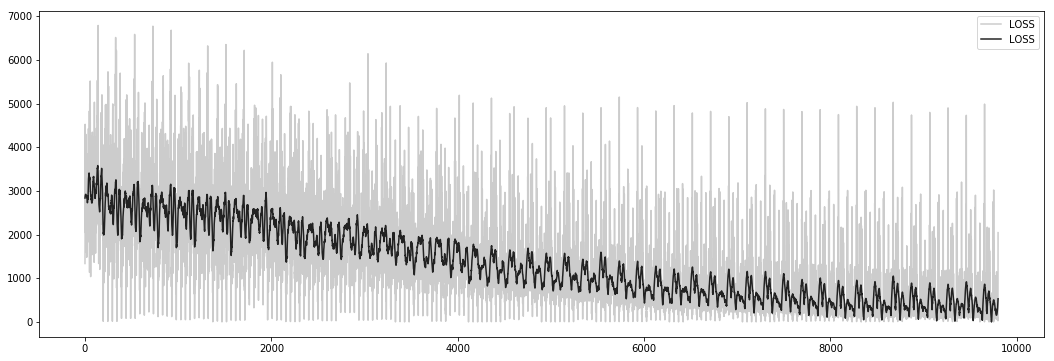

In [19]:
plt.rcParams["figure.figsize"] = [18,6]
fig, (ax1) = plt.subplots(nrows=1, ncols=1)
df = val.copy()
df['LOSS'] = savgol_filter(df['LOSS'], 51, 3)
plots = val.plot(y='LOSS', x=T_val, c='#cccccc', ax=ax1)
plots = df.plot(y='LOSS', x=T_val, c='#222222', ax=ax1)
plt.show()

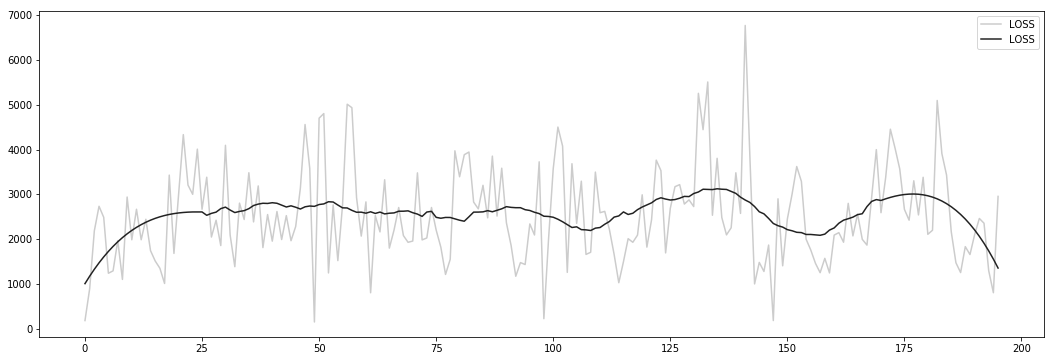

In [28]:
plt.rcParams["figure.figsize"] = [18,6]
fig, (ax1) = plt.subplots(nrows=1, ncols=1)
df = test.copy()
df['LOSS'] = savgol_filter(df['LOSS'], 51, 3)
plots = test.plot(y='LOSS', x=T_test, c='#cccccc', ax=ax1)
plots = df.plot(y='LOSS', x=T_test, c='#222222', ax=ax1)
plt.show()

### TEST Images

In [39]:
imap = Image()

In [337]:
file = '06_test.png'
imap.load_file(unetDRIVE['Dirs']['image'],  '06_test.tif')
# imap.res['unet'] = iu.get_image_as_array(unetDRIVE['Dirs']['image']+sep+file, channels=1)
imap.res['thrnet'] = iu.get_image_as_array(unetDRIVE['Dirs']['logs']+sep+file, channels=1)
imap.load_ground_truth(unetDRIVE['Dirs']['truth'], unetDRIVE['Funcs']['truth_getter'])
imap.load_mask(unetDRIVE['Dirs']['mask'], unetDRIVE['Funcs']['mask_getter'])

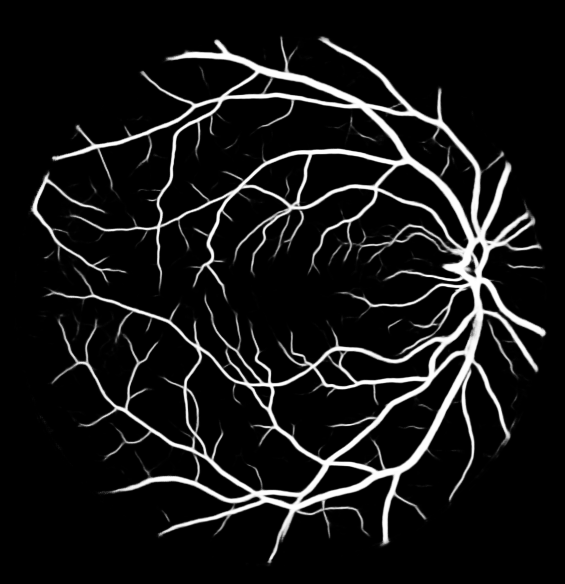

In [338]:
IMG.fromarray(imap.res['thrnet'])

In [339]:
# ig = imap.res['thrnet'].copy()
# ig[imap.mask==0] = 0
# # iu.get_praf1(ig, imap.ground_truth)

In [340]:
# IMG.fromarray(imap.ground_truth)

### Find manual scores with threshodl for each batch

In [341]:
get_best_f1_thr(imap.res['thrnet'], imap.ground_truth)

({'Accuracy': 0.96556, 'F1': 0.81965, 'Precision': 0.83577, 'Recall': 0.80415},
 102.0)

### Generate an estimate with low threshold

In [342]:
j = imap.res['thrnet'].copy()
j[j>20] = 255
j[j<=20]=0
iu.get_praf1(j, imap.ground_truth)

{'Accuracy': 0.94571, 'F1': 0.76488, 'Precision': 0.66111, 'Recall': 0.9073}

### Remove small connected components from the estimate

In [345]:
structure = np.ones((3, 3), dtype=np.int)
labeled, ncomponents = label(j, structure)
for i in range(ncomponents):
    ixy = np.array(list(zip(*np.where(labeled == i))))
    x1, y1 = ixy[0]
    x2, y2 = ixy[-1]
    dst = math.sqrt((x2-x1)**2+(y2-y1)**2)
    if dst < 10:
        for u, v in ixy:
            j[u, v] = 0

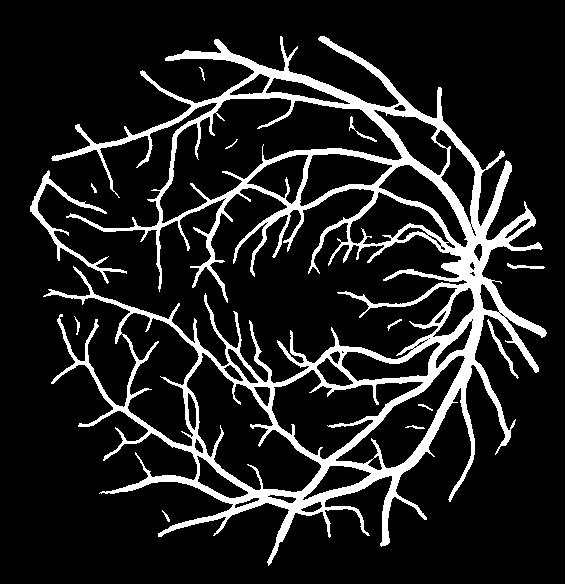

In [346]:
IMG.fromarray(j)

### Skeletonize

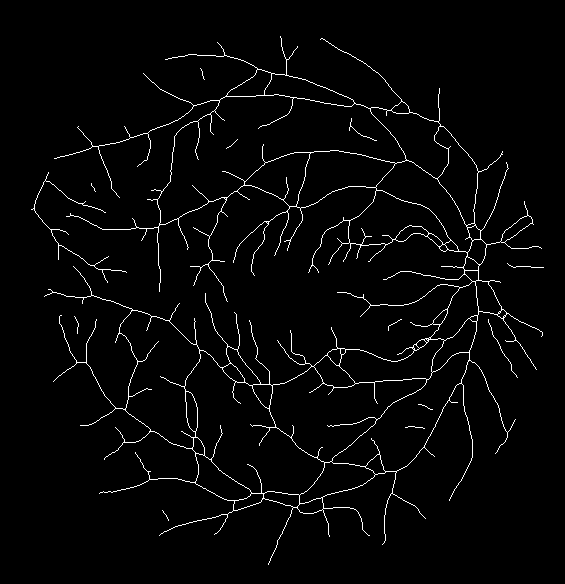

In [371]:
ski = j.copy()
ski[ski==255]=1
sk = skeletonize(ski) * 255
sk = sk.astype(np.uint8)
IMG.fromarray(np.array(sk, dtype=np.uint8))

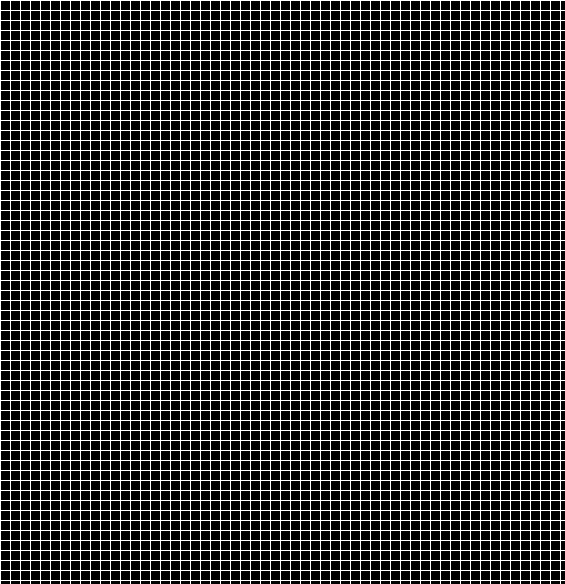

In [380]:
mask = np.zeros_like(sk)
mask[::10] = 255
mask[:,::10] = 255
IMG.fromarray(mask)

In [377]:
import cv2
mask[mask==255]=1
sk[sk==255]=1
masked = sk*mask
masked=masked*255

1596


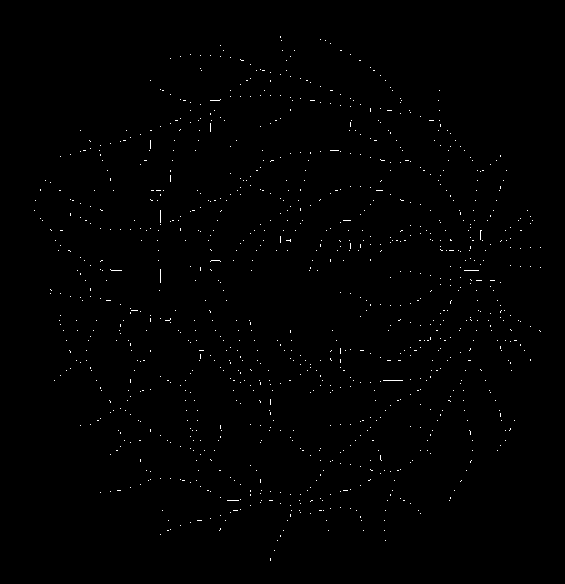

In [378]:
IMG.fromarray(masked)

### Get pixel indices and generate patch indices around those pixel indices

In [243]:
myind = list(zip(*np.where(masked == 255)))
myind_good = list(iu.get_chunk_indices_by_index(imap.ground_truth.shape, (16,16), indices=myind))
print(len(myind), len(myind_good))

18441 18441


In [498]:
myind_sk = list(zip(*np.where(masked == 255)))
myind_sk_patch = list(iu.get_chunk_indices_by_index(imap.ground_truth.shape, (16,16), indices=myind_sk))
len(myind_sk_patch)

1596

In [517]:
kernel = np.ones((10,10), np.uint8) 
my[my==255]=1
eroded = cv2.dilate(my, kernel, iterations=1) 
eroded = eroded * 255
eroded[imap.mask==0]=255

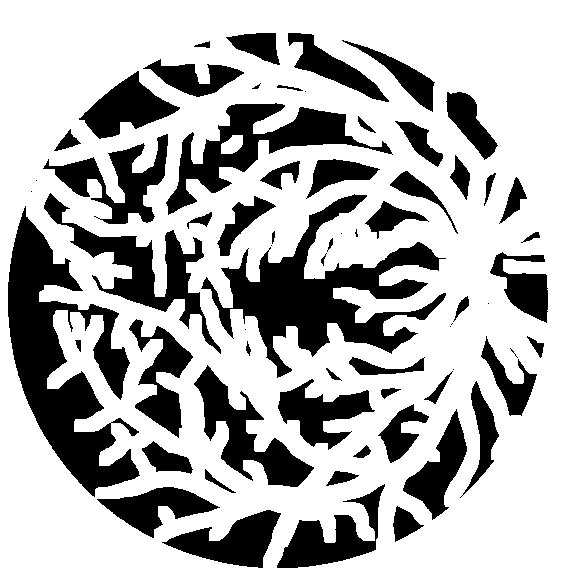

In [521]:
IMG.fromarray(eroded)

### Reconstruct image from the newly choosen vessel pixels

In [500]:
# best_ix = list(iu.get_chunk_indices_by_index(imap.ground_truth.shape, (16,16), indices=best))
my = np.zeros_like(sk)
for p, q, r, s in myind_sk_patch:
    my[p:q, r:s] = j[p:q,r:s]

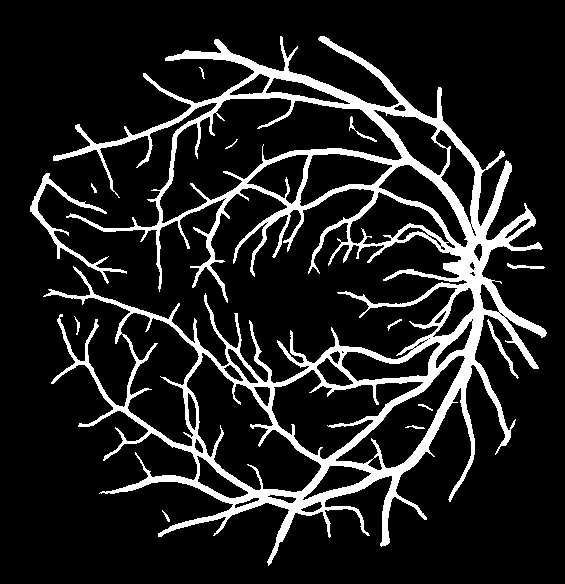

In [501]:
IMG.fromarray(my)